In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from dotenv import load_dotenv
import mlflow
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
#Unprocessed (unscaled data)

raw_train_df = pd.read_csv("train/splits/train_split.csv")
raw_test_df = pd.read_csv("train/splits/test_split.csv")
raw_val_df = pd.read_csv("train/splits/val_split.csv")

In [4]:
raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77437 entries, 0 to 77436
Data columns (total 54 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   msno                                77437 non-null  object 
 1   city                                77437 non-null  float64
 2   bd                                  77437 non-null  float64
 3   gender                              77437 non-null  object 
 4   registered_via                      77437 non-null  float64
 5   registration_init_time              77437 non-null  object 
 6   num_25_mean                         77437 non-null  float64
 7   num_50_mean                         77437 non-null  float64
 8   num_50_min                          77437 non-null  float64
 9   num_50_max                          77437 non-null  float64
 10  num_50_std                          77437 non-null  float64
 11  num_75_mean                         77437

In [3]:
raw_train_df.head()

,msno,city,bd,gender,registered_via,registration_init_time,num_25_mean,num_50_mean,num_50_min,num_50_max,...,membership_expire_day_of_week_mean,membership_expire_month_mean,membership_expire_month_count,last_transaction_date,is_churn,registration_year,registration_month,last_transaction_year,last_transaction_month,usage_period_days
0,P7W1hJVPC9+lZf5WLhskxKvQQEJJdpKkKVu4v7RA0zQ=,13.0,29.0,female,9.0,2004-03-26,2.86,0.00,0.0,0.0,...,3.0,4.0,1.0,2017-03-01,0.0,2004.0,3.0,2017.0,3.0,4723.0
1,yKDUvz1yO1xZ/fwG0bMyIa5K+w7+kIAc+qV3vZKYz9E=,22.0,36.0,female,9.0,2004-03-26,2.00,0.50,0.0,1.0,...,5.0,4.5,2.0,2017-03-31,0.0,2004.0,3.0,2017.0,3.0,4753.0
2,STy1UqGkW8U4LNr6usNMy5hpCt1fZs96eLFHmhnb0tE=,10.0,32.0,female,9.0,2004-03-26,3.00,0.50,0.0,1.0,...,6.0,4.0,1.0,2017-03-31,0.0,2004.0,3.0,2017.0,3.0,4753.0
3,35OTDI3ToY0rj1BtWTbDJ9YV8yDygsv1sNM08SQ7pQc=,22.0,33.0,female,9.0,2004-03-26,4.17,0.86,0.0,3.0,...,6.0,4.0,1.0,2017-03-31,0.0,2004.0,3.0,2017.0,3.0,4753.0
4,9CqDxOPBQwLzxCOywM3l763Yq4yFQhPhFFk79rPs5x0=,5.0,0.0,male,9.0,2004-03-26,4.11,3.83,0.0,19.0,...,0.0,4.0,1.0,2017-03-17,0.0,2004.0,3.0,2017.0,3.0,4739.0


## Preprocessing


In [11]:
TO_DROP = ["msno", "registration_init_time", "last_transaction_date"]
CATEGORICAL_FEATS = ["city", "gender", "registered_via", "registration_month", "last_transaction_month"]

def preprocess_df(df : pd.DataFrame):

    df_cp = df.copy()
    df_cp = df_cp.drop(TO_DROP, axis=1)
    ¶
    for name in CATEGORICAL_FEATS:
        df_cp[name] = df_cp[name].astype("category")


    return df_cp


In [12]:
#Apply preprocessing
train_df = preprocess_df(raw_train_df)
val_df = preprocess_df(raw_val_df)
test_df = preprocess_df(raw_test_df)

## Feature Processing

### Feature Importance Filtering
Looking at Feature Importances produced in first iteration, let's drop the most uninoformative ones.

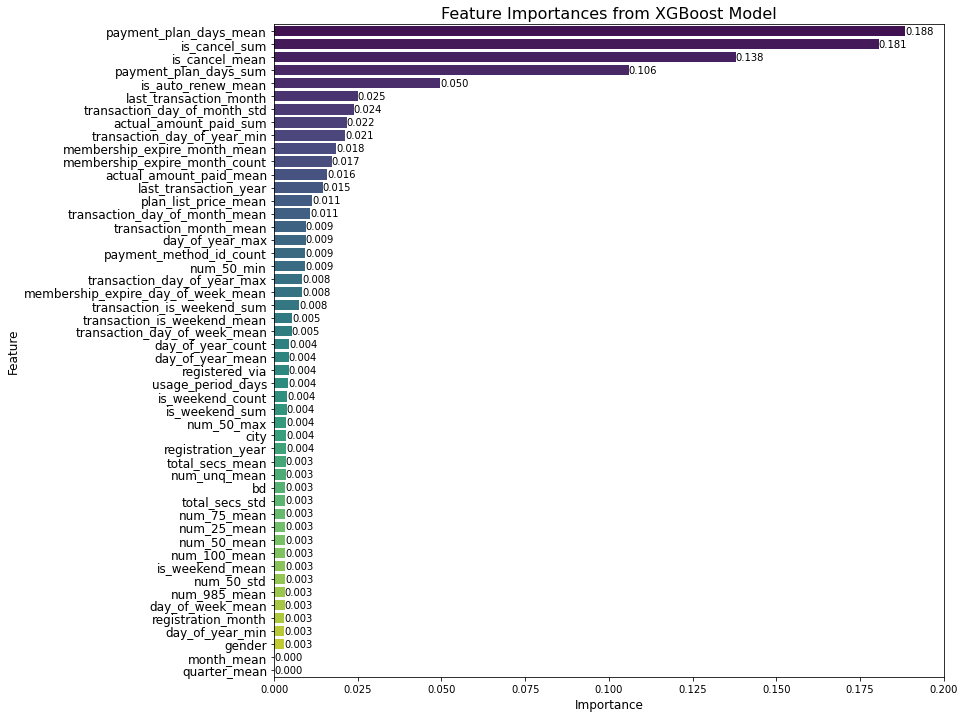

In [18]:
fi_df = pd.read_csv("artifacts/xgb_feat_importances_iter1.csv")

plt.figure(figsize=(12, 12))
sns.barplot(x="importance", y="feature", data=fi_df, palette="viridis")

for index, value in enumerate(fi_df["importance"]):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.title('Feature Importances from XGBoost Model', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xlim(0, 0.2)
plt.show()


In [160]:
fi_treshold = 0.0035

IMPORTANT_FEATURES = fi_df[fi_df["importance"] >= fi_treshold]["feature"].to_list()

print("Number of Important features left:", len(IMPORTANT_FEATURES))

Number of Important features left: 33


In [161]:
train_df_filt = train_df[IMPORTANT_FEATURES + ["is_churn"]]
val_df_filt = val_df[IMPORTANT_FEATURES + ["is_churn"]]
test_df_filt = test_df[IMPORTANT_FEATURES + ["is_churn"]]

In [162]:
train_df_filt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77437 entries, 0 to 77436
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   payment_plan_days_mean              77437 non-null  float64 
 1   is_cancel_sum                       77437 non-null  float64 
 2   is_cancel_mean                      77437 non-null  float64 
 3   payment_plan_days_sum               77437 non-null  float64 
 4   is_auto_renew_mean                  77437 non-null  float64 
 5   last_transaction_month              77437 non-null  category
 6   transaction_day_of_month_std        77437 non-null  float64 
 7   actual_amount_paid_sum              77437 non-null  float64 
 8   transaction_day_of_year_min         77437 non-null  float64 
 9   membership_expire_month_mean        77437 non-null  float64 
 10  membership_expire_month_count       77437 non-null  float64 
 11  actual_amount_paid_mean     

### Feature Correlation: Multicollinearity 

<Axes: title={'center': 'Correlation for Filtered DF'}>

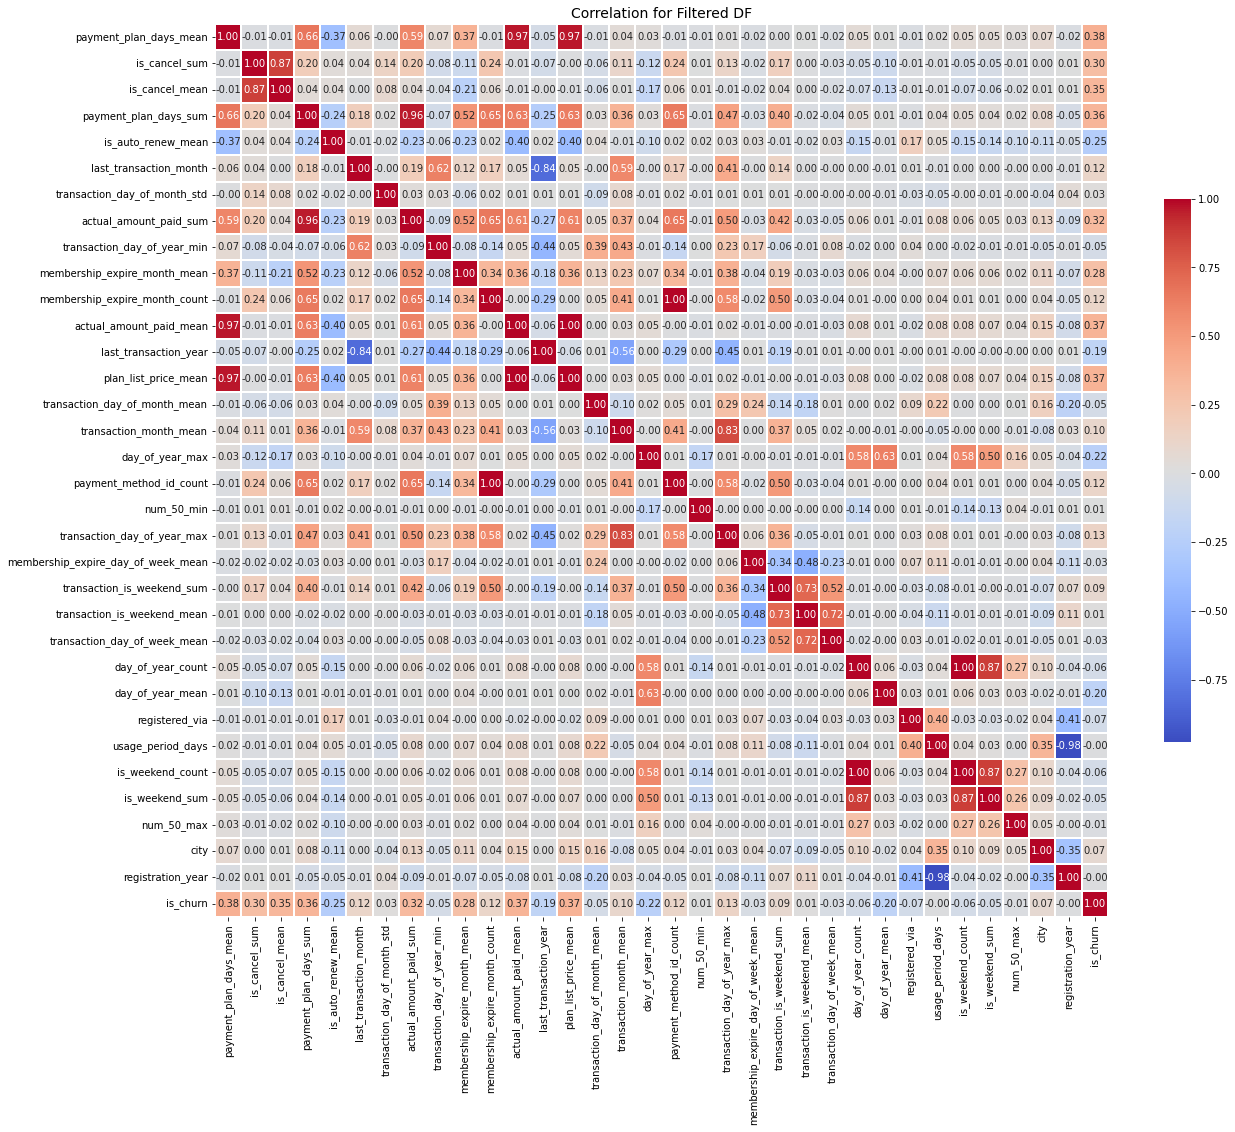

In [166]:
corr_matrix = train_df_filt.corr()
plt.figure(figsize=(20, 20))
plt.title("Correlation for Filtered DF", fontsize=14)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=1.5, cbar_kws={"shrink": 0.5})

**Observation:**

We clearly see that we have a **mutlicollinearity problem** because of the way we aggregated data (mean of some sample is highly correlated to sum as example). Some features are redundant because correlation is nearly 1 (e.g. payment plan days sum and actual_amount_paid_sum)

This is not a big problem in terms of performance of boosting algorithms, but it is an **issue in terms of interpretability**

In [173]:
# Create a boolean mask for the upper triangle of the correlation matrix
# Exclude the diagonal (k=1) and lower triangle, keeping only the upper triangle

high_corr_treshold = 0.75

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Identify the features that have a high correlation (> t) with any other feature
REDUNDANT_TO_DROP = [column for column in upper.columns if any(np.abs(upper[column]) > high_corr_treshold)]

REDUNDANT_TO_DROP

['is_cancel_mean',
 'actual_amount_paid_sum',
 'actual_amount_paid_mean',
 'last_transaction_year',
 'plan_list_price_mean',
 'payment_method_id_count',
 'transaction_day_of_year_max',
 'is_weekend_count',
 'is_weekend_sum',
 'registration_year']

In [174]:
#Remove redundant features to reduce multicolinearity

train_df_reduced = train_df_filt.drop(REDUNDANT_TO_DROP, axis=1)
val_df_reduced = val_df_filt.drop(REDUNDANT_TO_DROP, axis=1)
test_df_reduced = test_df_filt.drop(REDUNDANT_TO_DROP, axis=1)

**Looking at correlation  matrix again**

<Axes: title={'center': 'Correlation for Filtered DF without Redundant Features'}>

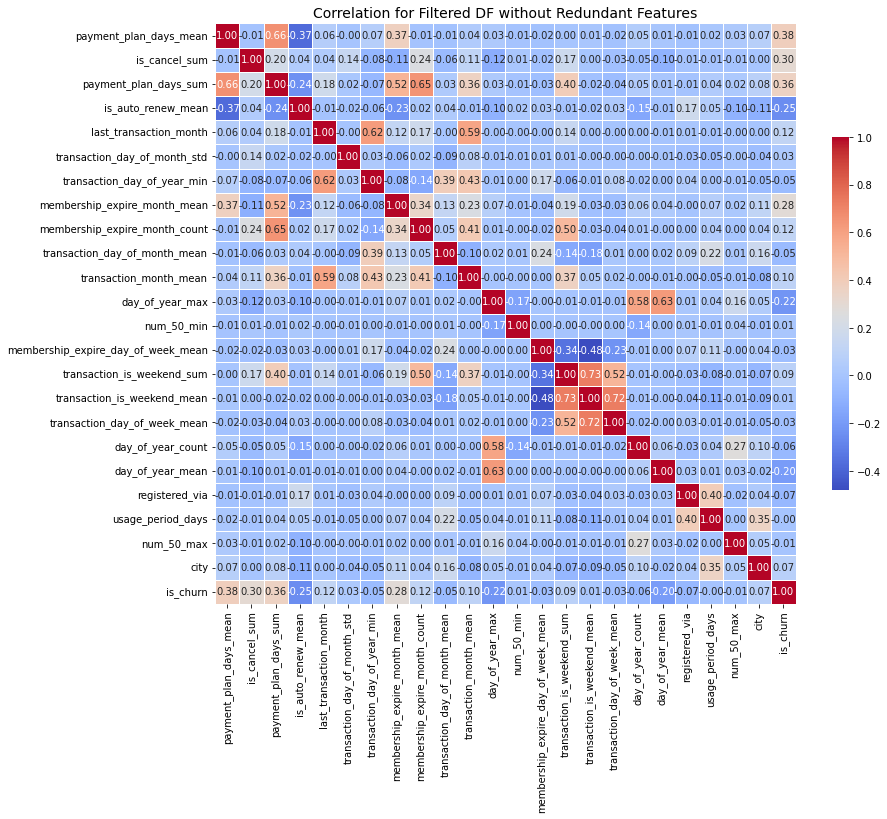

In [175]:
corr_matrix_red = train_df_reduced.corr()
plt.figure(figsize=(13, 13))
plt.title("Correlation for Filtered DF without Redundant Features", fontsize=14)
sns.heatmap(corr_matrix_red, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=1, cbar_kws={"shrink": 0.5})

Now, it looks much better because we don't have extremely correlated features. This step shouldn't hurt the performance of ml model, but it **will certainly improve or ability to interpret model's decision**

In [176]:
train_df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77437 entries, 0 to 77436
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   payment_plan_days_mean              77437 non-null  float64 
 1   is_cancel_sum                       77437 non-null  float64 
 2   payment_plan_days_sum               77437 non-null  float64 
 3   is_auto_renew_mean                  77437 non-null  float64 
 4   last_transaction_month              77437 non-null  category
 5   transaction_day_of_month_std        77437 non-null  float64 
 6   transaction_day_of_year_min         77437 non-null  float64 
 7   membership_expire_month_mean        77437 non-null  float64 
 8   membership_expire_month_count       77437 non-null  float64 
 9   transaction_day_of_month_mean       77437 non-null  float64 
 10  transaction_month_mean              77437 non-null  float64 
 11  day_of_year_max             

## Model Training

### Logistic Regression

In [177]:
X_train, y_train = train_df_reduced.drop("is_churn", axis=1), train_df_reduced["is_churn"]
X_val, y_val = val_df_reduced.drop("is_churn", axis=1), val_df_reduced["is_churn"]
X_test, y_test = test_df_reduced.drop("is_churn", axis=1), test_df_reduced["is_churn"]

In [178]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

def classification_report(y_true, y_pred, modelname):
    
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    print("====Classification Report for model:", modelname, "=========")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")


def find_best_threshold(y_true, y_probs):
    """
    Finds the best threshold for predicted probabilities to optimize F1 score.
    """
    best_threshold = 0.0
    best_f1 = 0.0

    # Evaluate F1 score for thresholds between 0.0 and 1.0
    for threshold in np.linspace(0, 1, 101):
        y_pred = (y_probs >= threshold).astype(int)
        current_f1 = f1_score(y_true, y_pred)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold

    return best_threshold    


logreg = LogisticRegression(random_state=2, l1_ratio=0.3, max_iter=5000)
logreg.fit(X_train, y_train)

clf_t = find_best_threshold(y_val, logreg.predict_proba(X_val)[:, 1])
y_pred = (logreg.predict_proba(X_val)[:, 1] >= clf_t).astype(int)

classification_report(y_val, y_pred, modelname="Logistic Regression")

====Classification Report for model: Logistic Regression =========
Precision: 0.5939
Recall:    0.7249
F1 Score:  0.6529


###  XGBoost model

In [179]:
from xgboost import XGBClassifier

def xgb_objective(trial):

    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 800),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'enable_categorical': True 
        #'device' : 'cuda'
    }


    clf = XGBClassifier(**param)
    clf.fit(X_train, y_train)
    clf_probs = clf.predict_proba(X_val)[:, 1]
    
    best_t = find_best_threshold(y_val, clf_probs)
    clf_predicts = (clf_probs >= best_t).astype(int)

    f1_metric = f1_score(y_val, clf_predicts)
    
    return f1_metric
    


xgb_study = optuna.create_study(direction="maximize")
xgb_study.optimize(xgb_objective, n_trials=30, timeout=2400)

xgb_trial = xgb_study.best_trial
print(f'Best trial for Gradient Boosting: {xgb_trial.params}')

xgb_study_df = xgb_study.trials_dataframe()
xgb_study_df.to_csv("xgb_study_f1_iter2.csv", index=False)

[I 2024-08-24 18:06:45,104] A new study created in memory with name: no-name-89fd6f30-2050-4942-b1b9-c066af6602f1
[I 2024-08-24 18:06:48,642] Trial 0 finished with value: 0.785425101214575 and parameters: {'max_depth': 2, 'learning_rate': 0.7994132240847188, 'n_estimators': 728, 'min_child_weight': 2, 'gamma': 1.0622444698530712e-07, 'subsample': 0.09850486087888356, 'colsample_bytree': 0.03616479221056149, 'reg_alpha': 1.0787840619917024e-05, 'reg_lambda': 1.2344456364944688e-07}. Best is trial 0 with value: 0.785425101214575.
[I 2024-08-24 18:06:51,755] Trial 1 finished with value: 0.8168604651162791 and parameters: {'max_depth': 1, 'learning_rate': 0.7616054463434747, 'n_estimators': 665, 'min_child_weight': 3, 'gamma': 0.001958439852261966, 'subsample': 0.6590503607592931, 'colsample_bytree': 0.27104691599499975, 'reg_alpha': 7.310328219181147e-05, 'reg_lambda': 0.00045387278426017803}. Best is trial 1 with value: 0.8168604651162791.
[I 2024-08-24 18:06:53,204] Trial 2 finished wit

Best trial for Gradient Boosting: {'max_depth': 7, 'learning_rate': 0.10572485467414411, 'n_estimators': 727, 'min_child_weight': 9, 'gamma': 0.025336375083602224, 'subsample': 0.1886075776018067, 'colsample_bytree': 0.6054445325481889, 'reg_alpha': 0.00010143546043445205, 'reg_lambda': 0.39320465065809695}


In [180]:
xgb_best_params = xgb_study.best_params

In [182]:
with open("artifacts/xgb_best_params_iter2.json", "w") as f:
    json.dump(xgb_best_params, f, indent=3)

xgb_best_params

{'max_depth': 7,
 'learning_rate': 0.10572485467414411,
 'n_estimators': 727,
 'min_child_weight': 9,
 'gamma': 0.025336375083602224,
 'subsample': 0.1886075776018067,
 'colsample_bytree': 0.6054445325481889,
 'reg_alpha': 0.00010143546043445205,
 'reg_lambda': 0.39320465065809695}

In [185]:
xgb_model = XGBClassifier(**xgb_best_params,
                          eval_metric="mlogloss", enable_categorical=True)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6054445325481889, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='mlogloss', feature_types=None,
              gamma=0.025336375083602224, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.10572485467414411, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=727, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [198]:
xgb_model_probs = xgb_model.predict_proba(X_val)[:, 1]
xgb_t = find_best_threshold(y_val, xgb_model_probs)
xgb_preds = (xgb_model_probs >= xgb_t).astype(int)

print("Treshold: ", xgb_t)
classification_report(y_val,  xgb_preds, "XGB")

Treshold:  0.22
====Classification Report for model: XGB =========
Precision: 0.7843
Recall:    0.8854
F1 Score:  0.8318
